In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Download NLTK assets
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [54]:
# Unzip the dataset file and store it in a folder called dataset.
!unzip "/content/drive/MyDrive/A Comprehensive Dataset for Automated Cyberbullying Detection.zip" -d "/content/dataset/"

Archive:  /content/drive/MyDrive/A Comprehensive Dataset for Automated Cyberbullying Detection.zip
replace /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/1. users_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/1. users_data.csv  
replace /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/6. CB_Labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/6. CB_Labels.csv  
replace /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/2. peerness_values.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/2. peerness_values.csv  
replace /content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/3. Aggressive_All.csv? [y]es, [n

In [55]:
import pandas as pd

# Load necessary CSV files from the extracted directory
cb_labels_df = pd.read_csv("/content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/6. CB_Labels.csv")
users_df = pd.read_csv("/content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/1. users_data.csv")
communication_df = pd.read_csv("/content/dataset/A Comprehensive Dataset for Automated Cyberbullying Detection/5. Communication_Data_Among_Users.csv")

In [56]:
import pandas as pd

# Merge user demographic info into CB_Labels
merged_df = cb_labels_df.merge(users_df, how='left', left_on='User1 ID', right_on='UserID', suffixes=('', '_User1'))
merged_df = merged_df.merge(users_df, how='left', left_on='User2 ID', right_on='UserID', suffixes=('', '_User2'))
merged_df.drop(columns=['UserID', 'UserID_User2'], inplace=True)

# Count number of messages and aggressive messages per (User1, User2)
communication_df['Message'] = communication_df['Message'].astype(str)
message_counts = communication_df.groupby(['User1 ID', 'User2 ID']).agg(
    num_messages=('Message', 'count'),
    num_aggressive=('Label', 'sum')
).reset_index()

# Merge back with demographic-enriched dataset
merged_df = merged_df.merge(message_counts, on=['User1 ID', 'User2 ID'], how='left')
merged_df[['num_messages', 'num_aggressive']] = merged_df[['num_messages', 'num_aggressive']].fillna(0)

In [57]:
merged_df.head()

,User1 ID,User2 ID,Total_messages,Aggressive_Count,Intent_to_Harm,Peerness,CB_Label,Age,Gender,School Name,Grade,Age_User2,Gender_User2,School Name_User2,Grade_User2,num_messages,num_aggressive
0,1,2,36,23,0.769444,0.500000,1,11,Others,School10,5,15,Male,School5,9,36,23
1,1,3,16,9,0.481250,0.766667,1,11,Others,School10,5,11,Male,School13,5,16,9
2,1,4,17,8,0.447794,0.366667,0,11,Others,School10,5,17,Male,School14,11,17,8
3,1,5,24,15,0.612500,0.366667,0,11,Others,School10,5,17,Male,School6,11,24,15
4,1,6,15,7,0.420833,0.433333,1,11,Others,School10,5,16,Male,School12,10,15,7


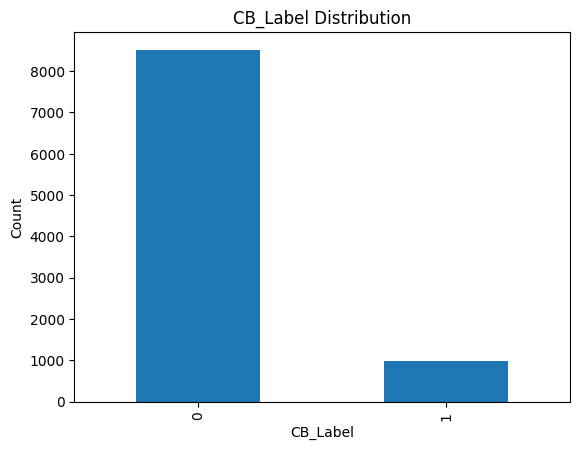

In [58]:
import matplotlib.pyplot as plt
merged_df['CB_Label'].value_counts().plot(kind='bar')
plt.title('CB_Label Distribution')
plt.xlabel('CB_Label')
plt.ylabel('Count')
plt.show()

# Pre-processing

In [59]:
# NLP Preprocessing Functions
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r"[^a-z\s]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [60]:
# Concatenate messages per dyad and preprocess
communication_df['Clean_Message'] = communication_df['Message'].apply(preprocess)
dyad_messages = communication_df.groupby(['User1 ID', 'User2 ID'])['Clean_Message'].apply(lambda msgs: ' '.join(msgs)).reset_index()

# Merge with CB_Labels to attach final labels
lstm_input_df = pd.merge(dyad_messages, cb_labels_df[['User1 ID', 'User2 ID', 'CB_Label']], on=['User1 ID', 'User2 ID'], how='inner')


In [61]:
lstm_input_df.head()

,User1 ID,User2 ID,Clean_Message,CB_Label
0,1,2,bye bye dear bajaj got better work watching ur...,1
1,1,3,bother fuckface suck cock dear gwernol u usele...,1
2,1,4,ron paul ron paul hasnt withdrawn thought id l...,0
3,1,5,vandalism disagree limey frustrating today cra...,0
4,1,6,rt fanwalker sexistbut theory female unable te...,1


# Duplicates and Missing Values

In [62]:
# How many reviews do we have?
print('There are', lstm_input_df.shape[0], 'data in this dataset')

# Do we have duplicates?
print('Number of Duplicates:', len(lstm_input_df[lstm_input_df.duplicated()]))

# Do we have missing values?
missing_values = lstm_input_df.isnull().sum()
print('Number of Missing Values by column:\n',missing_values)

print('Number of Missing Values:', lstm_input_df.isnull().sum().sum())

There are 9511 data in this dataset
Number of Duplicates: 0
Number of Missing Values by column:
 User1 ID         0
User2 ID         0
Clean_Message    0
CB_Label         0
dtype: int64
Number of Missing Values: 0


# Text Preparation for LSTM

In [63]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(lstm_input_df['Clean_Message'])

sequences = tokenizer.texts_to_sequences(lstm_input_df['Clean_Message'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=100)

# Data Splitting

In [64]:
# Split data into training and testing sets
X = padded_sequences
y = lstm_input_df['CB_Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (6657, 100)
Testing data shape: (2854, 100)
Training labels shape: (6657,)
Testing labels shape: (2854,)


# Data Balancing

In [66]:
from imblearn.over_sampling import RandomOverSampler

# Balance the dataset using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(padded_sequences, lstm_input_df['CB_Label'])

print(f"Shape of X after oversampling: {X_resampled.shape}")
print(f"Shape of y after oversampling: {y_resampled.shape}")

Shape of X after oversampling: (17038, 100)
Shape of y after oversampling: (17038,)


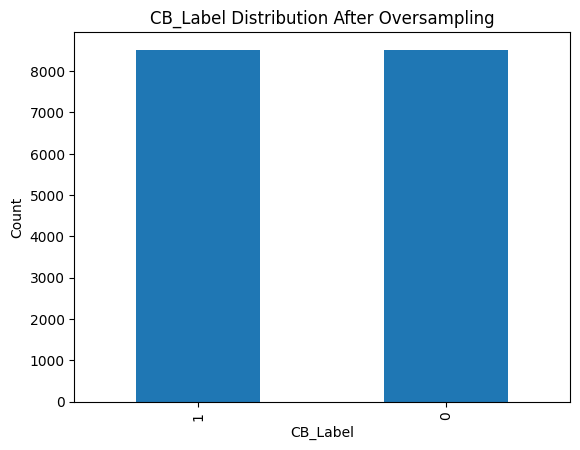

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Show the distribution of CB_Label after oversampling
pd.Series(y_resampled).value_counts().plot(kind='bar')
plt.title('CB_Label Distribution After Oversampling')
plt.xlabel('CB_Label')
plt.ylabel('Count')
plt.show()

# Model Definition

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np # Import numpy as it might be used with the model

# Define the original model architecture
model = Sequential([
    Embedding(5000, 64),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [80]:
from tensorflow.keras.layers import Bidirectional

# Define the complex model architecture
lstm_model_v2 = Sequential([
    Embedding(5000, 256),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model_v2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model_v2.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Training Simple Model on Imbalanced Data

In [81]:
from sklearn.model_selection import train_test_split

# Split imbalanced data into training and testing sets
# Assuming X and y still hold the imbalanced data before oversampling
X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape (unbalanced): {X_train_unbalanced.shape}")
print(f"Testing data shape (unbalanced): {X_test_unbalanced.shape}")
print(f"Training labels shape (unbalanced): {y_train_unbalanced.shape}")
print(f"Testing labels shape (unbalanced): {y_test_unbalanced.shape}")


# Train simple model on imbalanced data
history_simple_imbalanced = model.fit(X_train_unbalanced, y_train_unbalanced, epochs=10, validation_split=0.3, batch_size=32)

Training data shape (unbalanced): (7608, 100)
Testing data shape (unbalanced): (1903, 100)
Training labels shape (unbalanced): (7608,)
Testing labels shape (unbalanced): (1903,)
Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.8912 - loss: 0.3787 - val_accuracy: 0.8922 - val_loss: 0.3083
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9089 - loss: 0.2443 - val_accuracy: 0.8914 - val_loss: 0.3390
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9430 - loss: 0.1529 - val_accuracy: 0.8436 - val_loss: 0.4450
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9782 - loss: 0.0855 - val_accuracy: 0.8222 - val_loss: 0.5941
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9885 - loss: 0.0518 - val_accuracy: 0.8397 - val_loss: 0.6214
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9923 - loss: 0.0428 - val_accuracy: 0.8428 - val_loss: 0.7200
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/

### Evaluating Simple Model on Imbalanced Data

Simple Model (Imbalanced Data) Test Accuracy: 84.87%
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report (Simple Model - Imbalanced Data):
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1685
           1       0.17      0.08      0.11       218

    accuracy                           0.85      1903
   macro avg       0.53      0.52      0.51      1903
weighted avg       0.81      0.85      0.82      1903



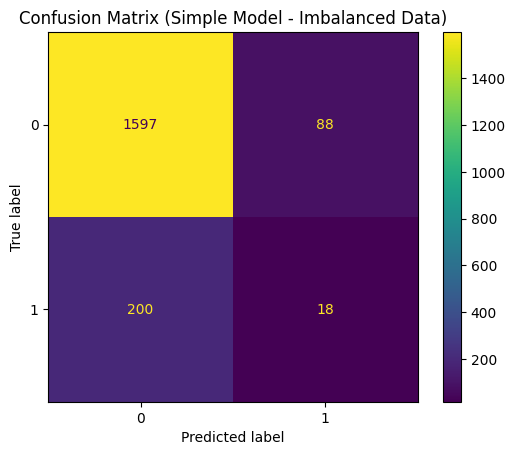

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the simple model trained on imbalanced data
loss_simple_imbalanced, accuracy_simple_imbalanced = model.evaluate(X_test_unbalanced, y_test_unbalanced, verbose=0)
print(f'Simple Model (Imbalanced Data) Test Accuracy: {accuracy_simple_imbalanced*100:.2f}%')

# Predictions and Evaluation Metrics for simple model on imbalanced data
y_pred_simple_imbalanced = (model.predict(X_test_unbalanced) > 0.5).astype("int32")

print("Classification Report (Simple Model - Imbalanced Data):")
print(classification_report(y_test_unbalanced, y_pred_simple_imbalanced))

cm_simple_imbalanced = confusion_matrix(y_test_unbalanced, y_pred_simple_imbalanced)
disp_simple_imbalanced = ConfusionMatrixDisplay(confusion_matrix=cm_simple_imbalanced)
disp_simple_imbalanced.plot()
plt.title('Confusion Matrix (Simple Model - Imbalanced Data)')
plt.show()

### Accuracy and Loss Graphs (Simple Model - Imbalanced Data)

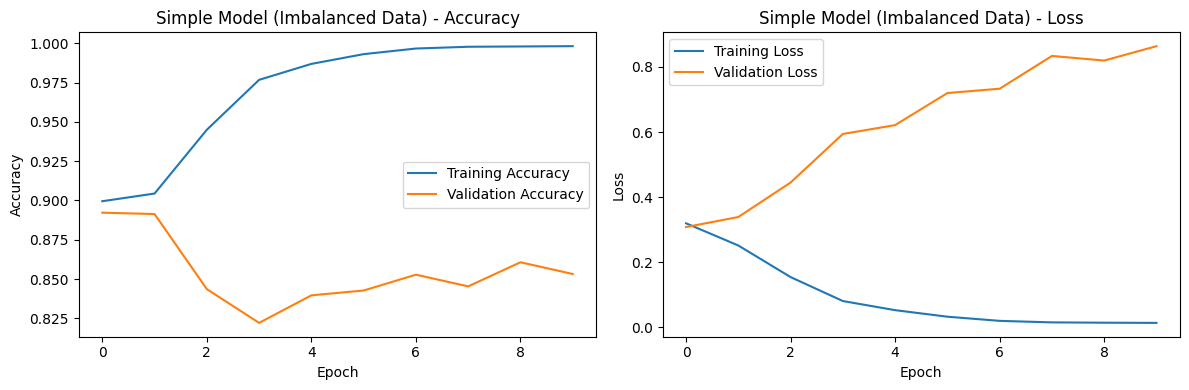

In [89]:
import matplotlib.pyplot as plt

# Plot training history for Simple Model on Imbalanced Data
if 'history_simple_imbalanced' in locals():
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_simple_imbalanced.history['accuracy'], label='Training Accuracy')
    plt.plot(history_simple_imbalanced.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Simple Model (Imbalanced Data) - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_simple_imbalanced.history['loss'], label='Training Loss')
    plt.plot(history_simple_imbalanced.history['val_loss'], label='Validation Loss')
    plt.title('Simple Model (Imbalanced Data) - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("History for Simple Model (Imbalanced Data) not found. Please run the training cell first.")

### Training Simple Model on Balanced Data

In [83]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Split balanced data into training and testing sets
# Assuming X_resampled and y_resampled hold the balanced data after oversampling
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Training data shape (balanced): {X_train_balanced.shape}")
print(f"Testing data shape (balanced): {X_test_balanced.shape}")
print(f"Training labels shape (balanced): {y_train_balanced.shape}")
print(f"Testing labels shape (balanced): {y_test_balanced.shape}")

# Redefine and recompile the simple model
model = Sequential([
    Embedding(5000, 64),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Train simple model on balanced data
history_simple_balanced = model.fit(X_train_balanced, y_train_balanced, epochs=10, validation_split=0.3, batch_size=32)

Training data shape (balanced): (11926, 100)
Testing data shape (balanced): (5112, 100)
Training labels shape (balanced): (11926,)
Testing labels shape (balanced): (5112,)
Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6808 - loss: 0.5722 - val_accuracy: 0.8292 - val_loss: 0.4120
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9105 - loss: 0.2632 - val_accuracy: 0.8946 - val_loss: 0.2971
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9659 - loss: 0.1206 - val_accuracy: 0.9100 - val_loss: 0.3179
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9855 - loss: 0.0631 - val_accuracy: 0.9050 - val_loss: 0.3816
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9844 - loss: 0.0617 - val_accuracy: 0.9357 - val_loss: 0.2809
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9916 - loss: 0.0339 - val_accuracy: 0.9360 - val_loss: 0.2853
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step -

### Evaluating Simple Model on Balanced Data

Simple Model (Balanced Data) Test Accuracy: 93.51%
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report (Simple Model - Balanced Data):
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      2586
           1       0.89      0.99      0.94      2526

    accuracy                           0.94      5112
   macro avg       0.94      0.94      0.93      5112
weighted avg       0.94      0.94      0.93      5112



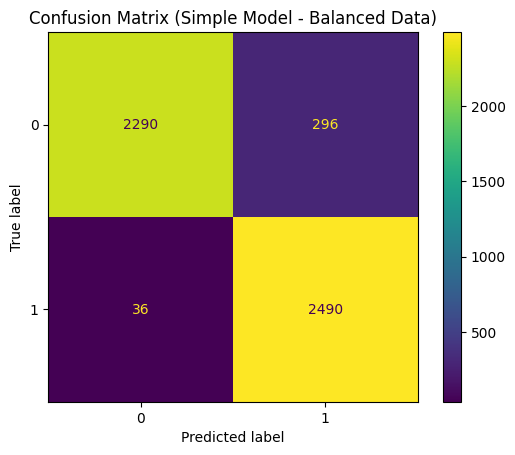

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the simple model trained on balanced data
loss_simple_balanced, accuracy_simple_balanced = model.evaluate(X_test_balanced, y_test_balanced, verbose=0)
print(f'Simple Model (Balanced Data) Test Accuracy: {accuracy_simple_balanced*100:.2f}%')

# Predictions and Evaluation Metrics for simple model on balanced data
y_pred_simple_balanced = (model.predict(X_test_balanced) > 0.5).astype("int32")

print("Classification Report (Simple Model - Balanced Data):")
print(classification_report(y_test_balanced, y_pred_simple_balanced))

cm_simple_balanced = confusion_matrix(y_test_balanced, y_pred_simple_balanced)
disp_simple_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_simple_balanced)
disp_simple_balanced.plot()
plt.title('Confusion Matrix (Simple Model - Balanced Data)')
plt.show()

### Accuracy and Loss Graphs (Simple Model - Balanced Data)

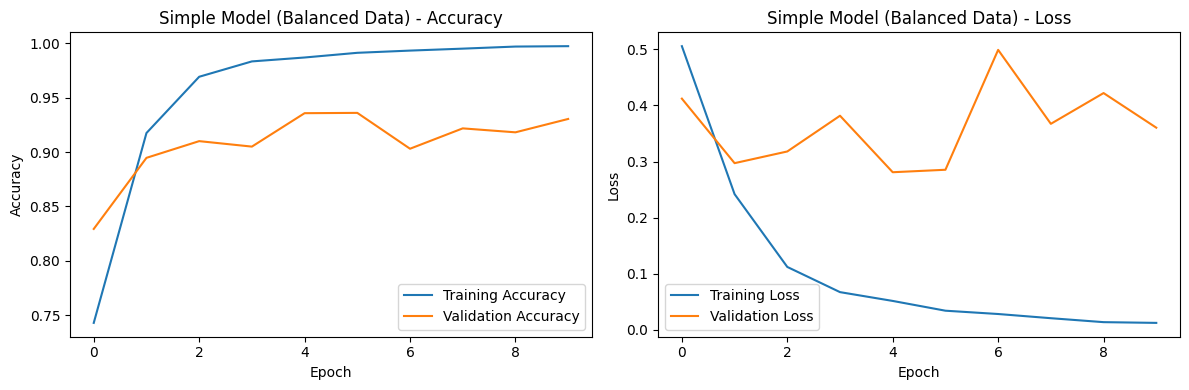

In [90]:
import matplotlib.pyplot as plt

# Plot training history for Simple Model on Balanced Data
if 'history_simple_balanced' in locals():
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_simple_balanced.history['accuracy'], label='Training Accuracy')
    plt.plot(history_simple_balanced.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Simple Model (Balanced Data) - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_simple_balanced.history['loss'], label='Training Loss')
    plt.plot(history_simple_balanced.history['val_loss'], label='Validation Loss')
    plt.title('Simple Model (Balanced Data) - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
     print("History for Simple Model (Balanced Data) not found. Please run the training cell first.")

### Training Complex Model on Imbalanced Data

In [85]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam


# Split imbalanced data into training and testing sets
# Assuming X and y still hold the imbalanced data before oversampling
X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape (unbalanced): {X_train_unbalanced.shape}")
print(f"Testing data shape (unbalanced): {X_test_unbalanced.shape}")
print(f"Training labels shape (unbalanced): {y_train_unbalanced.shape}")
print(f"Testing labels shape (unbalanced): {y_train_unbalanced.shape}")


# Redefine and recompile the complex model
complex_model = Sequential([
    Embedding(5000, 256),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

complex_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Train complex_model on imbalanced data
history_complex_imbalanced = complex_model.fit(X_train_unbalanced, y_train_unbalanced, epochs=10, validation_split=0.3, batch_size=32)

Training data shape (unbalanced): (7608, 100)
Testing data shape (unbalanced): (1903, 100)
Training labels shape (unbalanced): (7608,)
Testing labels shape (unbalanced): (7608,)
Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.8798 - loss: 0.3638 - val_accuracy: 0.8922 - val_loss: 0.3133
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9090 - loss: 0.2666 - val_accuracy: 0.8918 - val_loss: 0.3277
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9313 - loss: 0.2006 - val_accuracy: 0.8436 - val_loss: 0.3994
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9660 - loss: 0.1065 - val_accuracy: 0.8594 - val_loss: 0.4679
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9908 - loss: 0.0492 - val_accuracy: 0.8327 - val_loss: 0.6180
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9914 - loss: 0.0346 - val_accuracy: 0.8138 - val_loss: 0.7773
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 30

### Evaluating Complex Model on Imbalanced Data

Complex Model (Imbalanced Data) Test Accuracy: 83.03%
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Classification Report (Complex Model - Imbalanced Data):
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1685
           1       0.18      0.14      0.16       218

    accuracy                           0.83      1903
   macro avg       0.54      0.53      0.53      1903
weighted avg       0.81      0.83      0.82      1903



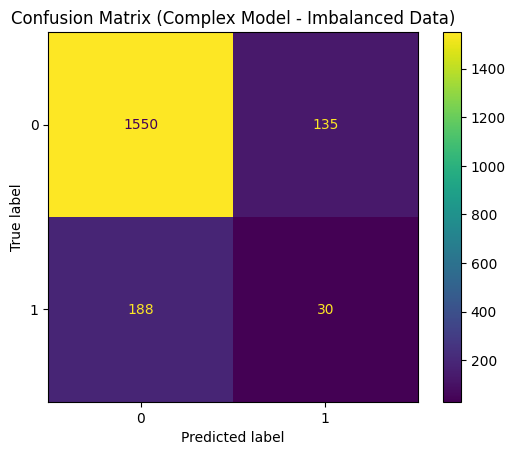

In [86]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the complex_model trained on imbalanced data
loss_complex_unbalanced, accuracy_complex_unbalanced = complex_model.evaluate(X_test_unbalanced, y_test_unbalanced, verbose=0)
print(f'Complex Model (Imbalanced Data) Test Accuracy: {accuracy_complex_unbalanced*100:.2f}%')

# Predictions and Evaluation Metrics for complex_model on imbalanced data
y_pred_complex_unbalanced = (complex_model.predict(X_test_unbalanced) > 0.5).astype("int32")

print("Classification Report (Complex Model - Imbalanced Data):")
print(classification_report(y_test_unbalanced, y_pred_complex_unbalanced))

cm_complex_unbalanced = confusion_matrix(y_test_unbalanced, y_pred_complex_unbalanced)
disp_complex_unbalanced = ConfusionMatrixDisplay(confusion_matrix=cm_complex_unbalanced)
disp_complex_unbalanced.plot()
plt.title('Confusion Matrix (Complex Model - Imbalanced Data)')
plt.show()

### Accuracy and Loss Graphs (Complex Model - Imbalanced Data)

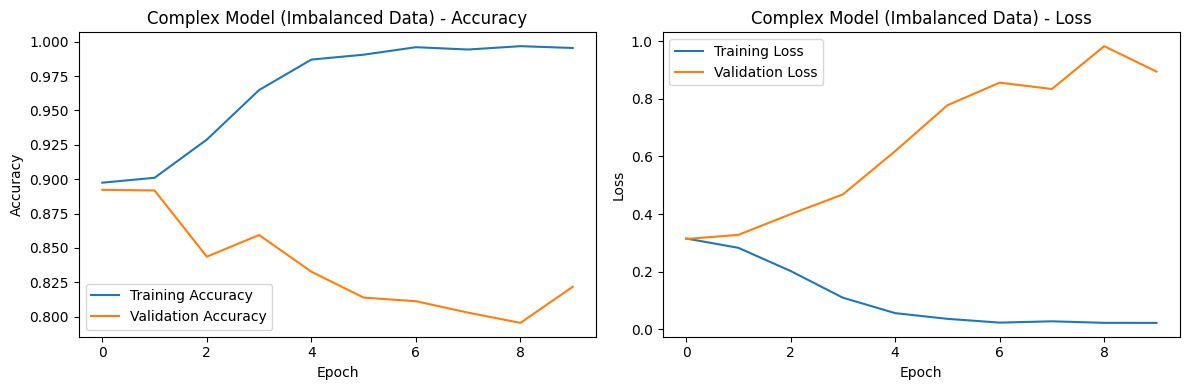

In [91]:
import matplotlib.pyplot as plt

# Plot training history for Complex Model on Imbalanced Data
if 'history_complex_imbalanced' in locals():
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_complex_imbalanced.history['accuracy'], label='Training Accuracy')
    plt.plot(history_complex_imbalanced.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Complex Model (Imbalanced Data) - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_complex_imbalanced.history['loss'], label='Training Loss')
    plt.plot(history_complex_imbalanced.history['val_loss'], label='Validation Loss')
    plt.title('Complex Model (Imbalanced Data) - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("History for Complex Model (Imbalanced Data) not found. Please run the training cell first.")

### Training Complex Model on Balanced Data

In [87]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Split balanced data into training and testing sets
# Assuming X_resampled and y_resampled hold the balanced data after oversampling
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Training data shape (balanced): {X_train_balanced.shape}")
print(f"Testing data shape (balanced): {X_test_balanced.shape}")
print(f"Training labels shape (balanced): {y_train_balanced.shape}")
print(f"Testing labels shape (balanced): {y_test_balanced.shape}")

# Redefine and recompile the complex model
complex_model = Sequential([
    Embedding(5000, 256),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

complex_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Train complex_model on balanced data
history_complex_balanced = complex_model.fit(X_train_balanced, y_train_balanced, epochs=10, validation_split=0.3, batch_size=32)

Training data shape (balanced): (11926, 100)
Testing data shape (balanced): (5112, 100)
Training labels shape (balanced): (11926,)
Testing labels shape (balanced): (5112,)
Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.7021 - loss: 0.5499 - val_accuracy: 0.8603 - val_loss: 0.3576
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9414 - loss: 0.1912 - val_accuracy: 0.9025 - val_loss: 0.3014
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9772 - loss: 0.0923 - val_accuracy: 0.8927 - val_loss: 0.3703
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.9854 - loss: 0.0641 - val_accuracy: 0.9114 - val_loss: 0.3481
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9875 - loss: 0.0545 - val_accuracy: 0.8941 - val_loss: 0.3863
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9872 - loss: 0.0503 - val_accuracy: 0.9195 - val_loss: 0.3336
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step

### Evaluating Complex Model on Balanced Data

Complex Model (Balanced Data) Test Accuracy: 94.50%
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Classification Report (Complex Model - Balanced Data):
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      2586
           1       0.91      0.98      0.95      2526

    accuracy                           0.95      5112
   macro avg       0.95      0.95      0.95      5112
weighted avg       0.95      0.95      0.94      5112



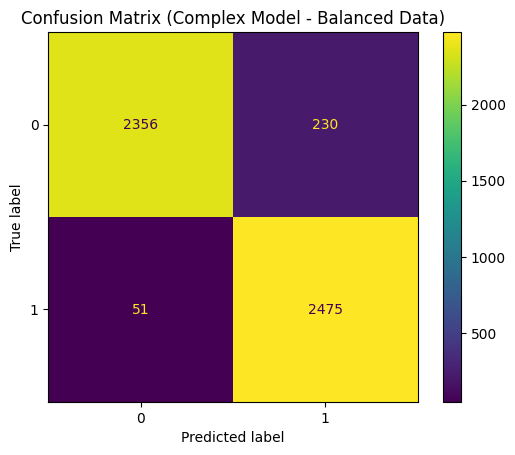

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the complex_model trained on balanced data
loss_complex_balanced, accuracy_complex_balanced = complex_model.evaluate(X_test_balanced, y_test_balanced, verbose=0)
print(f'Complex Model (Balanced Data) Test Accuracy: {accuracy_complex_balanced*100:.2f}%')

# Predictions and Evaluation Metrics for complex_model on balanced data
y_pred_complex_balanced = (complex_model.predict(X_test_balanced) > 0.5).astype("int32")

print("Classification Report (Complex Model - Balanced Data):")
print(classification_report(y_test_balanced, y_pred_complex_balanced))

cm_complex_balanced = confusion_matrix(y_test_balanced, y_pred_complex_balanced)
disp_complex_balanced = ConfusionMatrixDisplay(confusion_matrix=cm_complex_balanced)
disp_complex_balanced.plot()
plt.title('Confusion Matrix (Complex Model - Balanced Data)')
plt.show()

### Accuracy and Loss Graphs (Complex Model - Balanced Data)

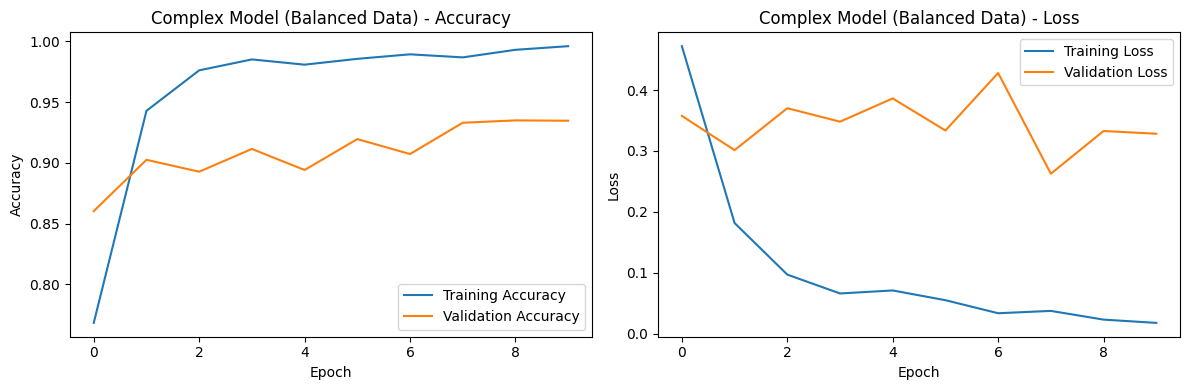

In [92]:
import matplotlib.pyplot as plt

# Plot training history for Complex Model on Balanced Data
if 'history_complex_balanced' in locals():
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_complex_balanced.history['accuracy'], label='Training Accuracy')
    plt.plot(history_complex_balanced.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Complex Model (Balanced Data) - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_complex_balanced.history['loss'], label='Training Loss')
    plt.plot(history_complex_balanced.history['val_loss'], label='Validation Loss')
    plt.title('Complex Model (Balanced Data) - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("History for Complex Model (Balanced Data) not found. Please run the training cell first.")

### Comparison of Model Performance Across Scenarios

Here's a comparison of the key evaluation metrics for the simple and complex models trained on both imbalanced and balanced datasets. Note the performance, particularly the recall and F1-score for the minority class (CB_Label 1), as this is often a crucial metric in imbalanced classification tasks.

| Scenario                      | Overall Accuracy | Class 0 Precision | Class 0 Recall | Class 0 F1-score | Class 1 Precision | Class 1 Recall | Class 1 F1-score |
|-------------------------------|------------------|-------------------|----------------|------------------|-------------------|----------------|------------------|
| Simple Model (Imbalanced)     | 0.8487 | 0.89 | 0.95 | 0.92 | 0.17 | 0.08 | 0.11 |
| Simple Model (Balanced)       | 0.9351 | 0.98 | 0.89 | 0.93 | 0.89 | 0.99 | 0.94 |
| Complex Model (Imbalanced)    | 0.8303 | 0.89 | 0.92 | 0.91 | 0.18 | 0.14 | 0.16 |
| Complex Model (Balanced)      | 0.9450 | 0.98 | 0.91 | 0.94 | 0.91 | 0.98 | 0.95 |

**Observations from Evaluation Metrics:**

Based on the values in the table:

*   **Overall Accuracy:** Both models show a significant increase in overall accuracy when trained on balanced data compared to imbalanced data. The complex model trained on balanced data achieves the highest overall accuracy (0.9450).
*   **Performance on Class 1 (Cyberbullying):** This is where the most significant impact of data balancing is observed.
    *   For the **Simple Model**, balancing the data dramatically improved Class 1 performance, increasing Recall from 0.08 to 0.99 and F1-score from 0.11 to 0.94. Precision also increased significantly from 0.17 to 0.89.
    *   For the **Complex Model**, balancing the data also significantly improved Class 1 performance, increasing Recall from 0.14 to 0.98 and F1-score from 0.16 to 0.95. Precision also increased from 0.18 to 0.91.
    *   Comparing the **balanced** scenarios, the Complex Model achieves slightly better Class 1 metrics (Precision 0.91, Recall 0.98, F1-score 0.95) compared to the Simple Model (Precision 0.89, Recall 0.99, F1-score 0.94), although the Simple Model on balanced data has a slightly higher Recall.
*   **Performance on Class 0 (Non-Cyberbullying):** While overall high in all scenarios, the Recall for Class 0 decreases slightly for both models when trained on balanced data compared to imbalanced data. This is a common trade-off when improving recall for the minority class in imbalanced datasets.
*   **Complex vs. Simple Model on Balanced Data:** On the balanced dataset, the complex model shows slightly better overall performance and slightly better Class 1 precision and F1-score compared to the simple model, while the simple model has slightly better Class 1 recall. The more complex architecture appears to provide a marginal improvement in this case.

**Observations from Accuracy and Loss Graphs:**

*   **Simple Model (Imbalanced Data):** The training accuracy increases rapidly and reaches nearly 1.0, while the validation accuracy plateaus early and then fluctuates. The training loss decreases steadily, but the validation loss increases significantly after a few epochs. This indicates **significant overfitting**. The model is learning the training data very well but is not generalizing to unseen validation data.
*   **Simple Model (Balanced Data):** The training accuracy increases steadily and reaches a high level, while the validation accuracy also increases and stays relatively close to the training accuracy, though with some fluctuations. Both training and validation loss decrease and then stabilize, with the validation loss staying relatively close to the training loss. This suggests that **oversampling helped reduce overfitting**, and the model is generalizing much better compared to training on imbalanced data.
*   **Complex Model (Imbalanced Data):** Similar to the simple model on imbalanced data, the training accuracy quickly reaches a high level, while the validation accuracy plateaus early and fluctuates. The training loss decreases, but the validation loss increases significantly. This also indicates **significant overfitting**. The more complex architecture on imbalanced data doesn't prevent overfitting.
*   **Complex Model (Balanced Data):** Both training and validation accuracy increase and stay relatively close, with some fluctuations in validation accuracy. Both training and validation loss decrease and then stabilize, with the validation loss staying relatively close to the training loss. This suggests that **oversampling also helped the complex model generalize better** and significantly reduced overfitting compared to training on imbalanced data. The curves appear smoother and more stable compared to the simple model on balanced data, potentially indicating the complex model is utilizing the balanced data more effectively.

**Overall Conclusion:**

Data balancing using oversampling had a profound positive impact on the ability of both models to correctly identify instances of cyberbullying (Class 1), significantly improving Recall and F1-score for this minority class and drastically reducing overfitting as observed in the accuracy and loss curves. The complex model, particularly when trained on balanced data, achieved the best overall performance and strong metrics for both classes, demonstrating the benefit of both a more complex architecture and addressing data imbalance for this cyberbullying detection task. The accuracy and loss curves visually confirm that training on balanced data leads to much better generalization.